# 作業 : (Kaggle)鐵達尼生存預測

# [作業目標]
- 試著模仿範例寫法, 在鐵達尼生存預測中, 練習特徵重要性的寫作與觀察

# [作業重點]
- 仿造範例, 完成特徵重要性的計算, 並觀察對預測結果的影響 (In[3]~[5], Out[3]~[5]) 
- 仿造範例, 將兩個特徵重要性最高的特徵重組出新特徵, 並觀察對預測結果的影響 (In[8], Out[8]) 

In [1]:
# 做完特徵工程前的所有準備 (與前範例相同)
import pandas as pd
import numpy as np
import copy
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

data_path = '../data/'
df = pd.read_csv(data_path + 'titanic_train.csv')

train_Y = df['Survived']
df = df.drop(['PassengerId', 'Survived'] , axis=1)
df.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [2]:
# 因為需要把類別型與數值型特徵都加入, 故使用最簡版的特徵工程
LEncoder = LabelEncoder()
MMEncoder = MinMaxScaler()
for c in df.columns:
    df[c] = df[c].fillna(-1)
    if df[c].dtype == 'object':
        df[c] = LEncoder.fit_transform(list(df[c].values))
    df[c] = MMEncoder.fit_transform(df[c].values.reshape(-1, 1))
df.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1.0,0.121348,1.0,0.283951,0.125,0.0,0.769118,0.014151,0.000000,1.000000
1,0.0,0.213483,0.0,0.481481,0.125,0.0,0.876471,0.139136,0.557823,0.333333
2,1.0,0.396629,0.0,0.333333,0.000,0.0,0.983824,0.015469,0.000000,1.000000
3,0.0,0.305618,0.0,0.444444,0.125,0.0,0.072059,0.103644,0.380952,1.000000
4,1.0,0.016854,1.0,0.444444,0.000,0.0,0.694118,0.015713,0.000000,1.000000


In [3]:
# 隨機森林擬合後, 將結果依照重要性由高到低排序
estimator = RandomForestClassifier()
estimator.fit(df.values, train_Y)
feats = pd.Series(data=estimator.feature_importances_, index=df.columns)
feats = feats.sort_values(ascending=False)
feats

Sex         0.226377
Ticket      0.159105
Name        0.134949
Fare        0.131097
Age         0.123094
Cabin       0.094364
Pclass      0.043395
Parch       0.036538
SibSp       0.029624
Embarked    0.021458
dtype: float64

## 先用隨機森林對鐵達尼生存預測做訓練，再用其特徵重要性回答下列問題

# 作業1
* 將特徵重要性較低的一半特徵刪除後，再做生存率預估，正確率是否有變化?

In [4]:
# 原始特徵 + 隨機森林
train_X = MMEncoder.fit_transform(df)
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.80814557979024659

In [6]:
# 高重要性特徵 + 隨機森林
high_feature = list(feats[:3].index)
train_X = MMEncoder.fit_transform(df[high_feature])
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.802445645717212

# 作業2
* 將特徵重要性最高的兩個特徵做特徵組合，是否能再進一步提升預測力?

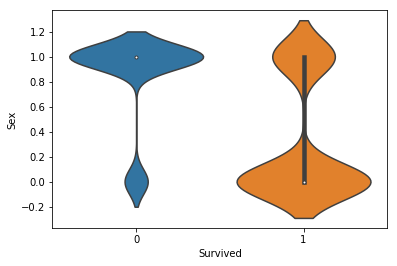

In [9]:
# 觀察重要特徵與目標的分布
# 第一名              
import seaborn as sns
import matplotlib.pyplot as plt
sns.violinplot(x=train_Y, y=df['Sex'], fit_reg=False, scale="width")
plt.show()

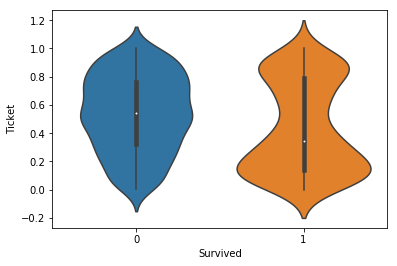

In [11]:
# 第二名       
sns.violinplot(x=train_Y, y=df['Ticket'], fit_reg=False)
plt.show()

In [12]:
# 製作四特徵 : 加, 乘, 互除(分母加1避免除0) 看效果 (Note: 數值原本已經最大最小化介於 [0,1] 區間, 這四種新特徵也會落在 [0,1] 區間)
df['Add_char'] = (df['Sex'] + df['Ticket']) / 2
df['Multi_char'] = df['Sex'] * df['Ticket']
df['GO_div1p'] = df['Sex'] / (df['Ticket']+1) * 2
df['OG_div1p'] = df['Ticket'] / (df['Sex']+1) * 2
train_X = MMEncoder.fit_transform(df)
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.82719013882963499

# df_test

In [15]:
df_test = pd.read_csv(data_path + 'titanic_test.csv')
ids = df_test['PassengerId']
df_test = df_test.drop(['PassengerId'] , axis=1)

In [16]:
LEncoder = LabelEncoder() #類別型
MMEncoder = MinMaxScaler() #數值型

In [17]:
for c in df_test.columns:
    df_test[c] = df_test[c].fillna(-1)
    if df_test[c].dtype == 'object':
        df_test[c] = LEncoder.fit_transform(list(df_test[c].values))
    df_test[c] = MMEncoder.fit_transform(df_test[c].values.reshape(-1, 1))

In [18]:
df_test.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1.0,0.494005,1.0,0.461039,0.000,0.000000,0.419890,0.017200,0.0,0.5
1,1.0,0.966427,0.0,0.623377,0.125,0.000000,0.610497,0.015585,0.0,1.0
2,0.5,0.645084,1.0,0.818182,0.000,0.000000,0.201657,0.020820,0.0,0.5
3,1.0,0.978417,1.0,0.363636,0.000,0.000000,0.406077,0.018823,0.0,1.0
4,1.0,0.426859,0.0,0.298701,0.125,0.111111,0.381215,0.025885,0.0,1.0


In [19]:
test_X = MMEncoder.fit_transform(df_test)

In [20]:
pred = estimator.predict(test_X)
sub = pd.DataFrame({'PassengerId': ids, 'Survived': pred})
sub.to_csv('../submission/titanic_baseline31.csv', index=False) 

In [21]:
sub.shape

(418, 2)